In [9]:
import logging
import os

import numpy as np

from aspire.noise import WhiteNoiseAdder
from aspire.source.simulation import Simulation
from aspire.utils import Rotation
from aspire.volume import Volume
from aspire.source import ArrayMicrographSource
from aspire import downloader


In [5]:
n_img = 10

In [16]:
# vol = downloader.emdb_2484()
vol = Volume.load("/Users/erik/Library/Caches/ASPIRE-data/EMDB-2484.mrc")
vol.downsample(60)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/erik/Library/Caches/ASPIRE-data/EMDB-2484.mrc'

In [11]:
vol.downsample(60)

1 float32 volumes arranged as a (1,) stack each of size 60x60x60 with pixel_size=4.608000183105469 angstroms.

In [12]:
# First get a list of angles to test
thetas = np.linspace(0, 2 * np.pi, num=n_img, endpoint=False)

# Instantiate ASPIRE's Rotation class with the set of angles.
# This will allow us to use or access the rotations in a variety of ways.
rots = Rotation.about_axis("z", thetas, dtype=np.float64)

In [13]:
noise_variance = 1e-10  # Normally this would be derived from a desired SNR.

# Then create a CustomNoiseAdder based on that variance, which is passed to Simulation.
white_noise_adder = WhiteNoiseAdder(var=noise_variance)

In [14]:
# Simulation will randomly shift and amplify images by default.
# Instead we define the following parameters.
shifts = np.zeros((n_img, 2))
amplitudes = np.ones(n_img)

# Create a Simulation Source object
src = Simulation(
    vols=vol,  # our Volume
    L=vol.resolution,  # resolution, should match Volume
    n=n_img,  # number of projection images
    angles=rots.angles,  # pass our rotations as Euler angles
    offsets=shifts,  # translations (wrt to origin)
    amplitudes=amplitudes,  # amplification ( 1 is identity)
    seed=12345,  # RNG seed for reproducibility
    dtype=vol.dtype,  # match our datatype to the Volume.
    noise_adder=white_noise_adder,  # optionally prescribe noise
)

2024-11-16 17:27:36,649 INFO [aspire.source.image] Creating Simulation with 10 images.
2024-11-16 17:27:36,651 INFO [aspire.source.simulation] Appending WhiteNoiseAdder with variance=1e-10 to generation pipeline


/Users/erik/Personal_Projects/Thesis/ThesisEnv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3508: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  exec(code_obj, self.user_global_ns, self.user_ns)


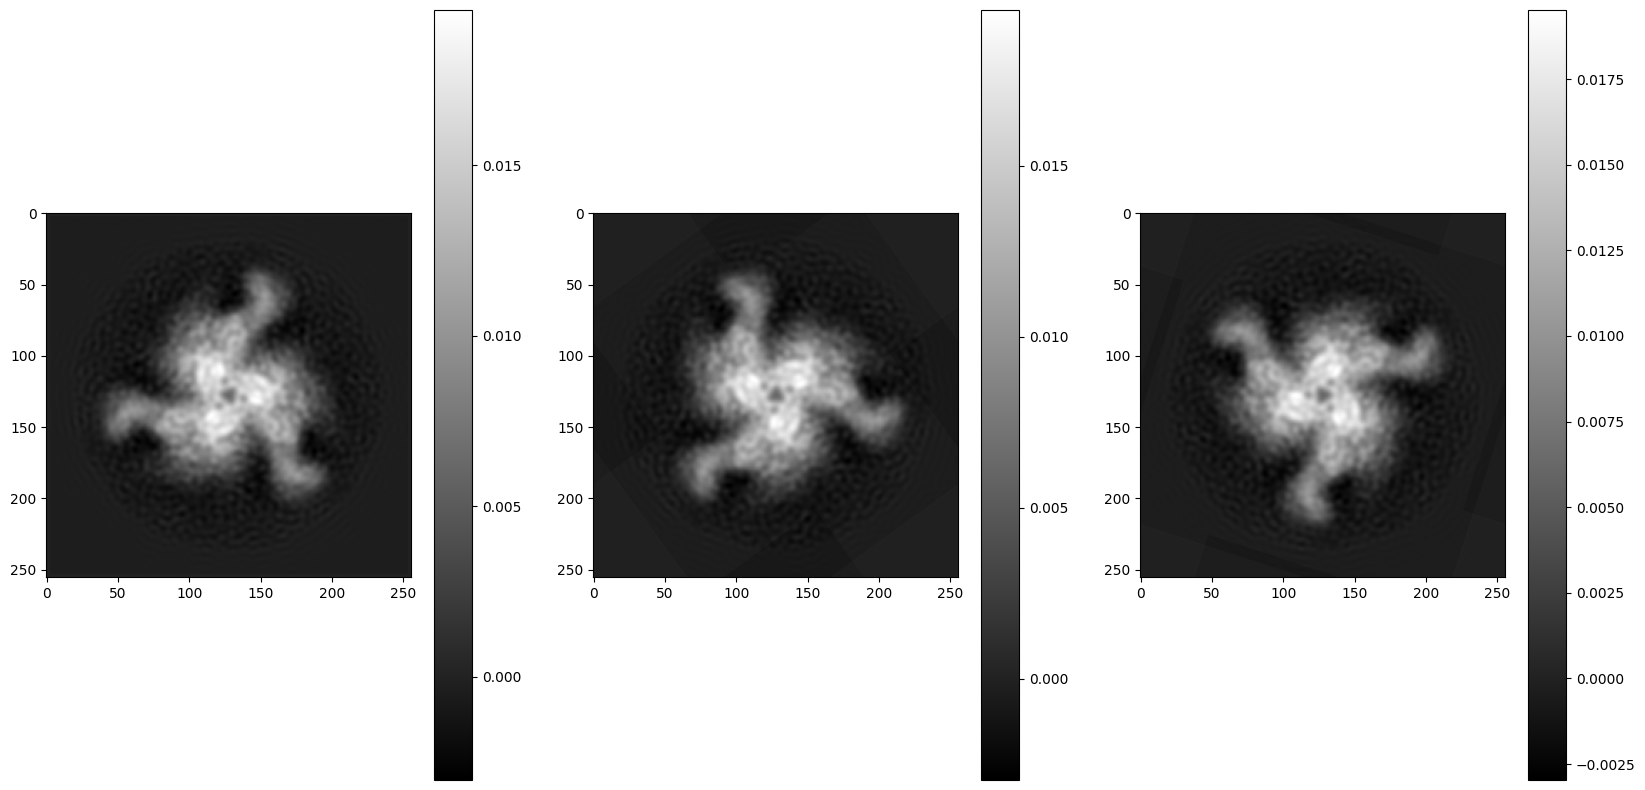

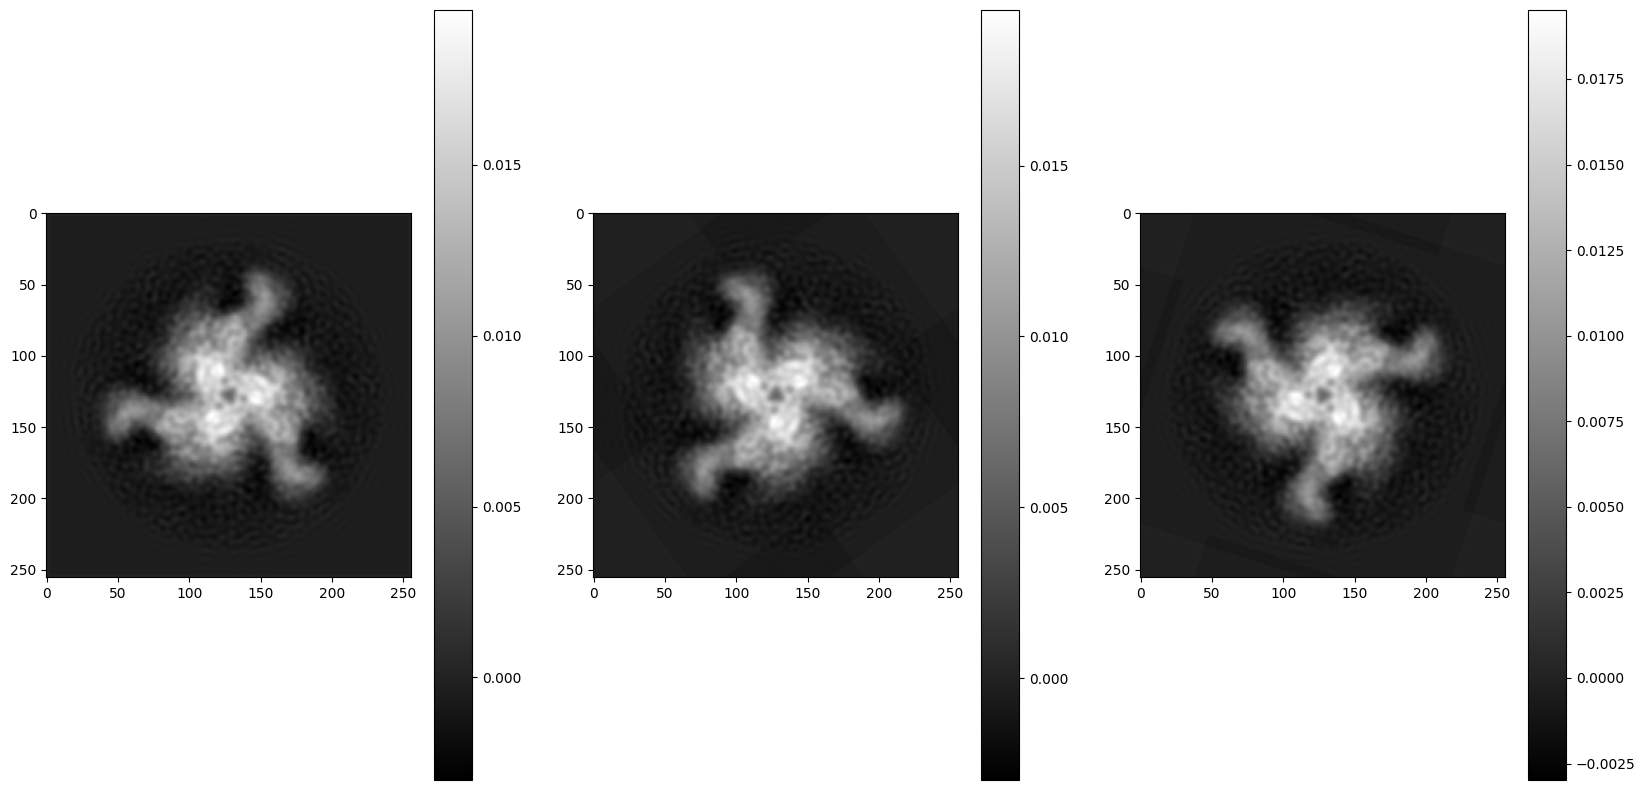

In [15]:
# Consume images from the source by providing
# a starting index and number of images.
# Here we generate the first 3 and peek at them.
src.images[:3].show()
src.projections[:3].show()

# Here we return the first n_img images as a numpy array.
dirty_ary = src.images[:n_img].asnumpy()

# And we have access to the clean images
clean_ary = src.projections[:n_img].asnumpy()

# Similary, the angles/rotations/shifts/amplitudes etc.